## Advanced Lane Finding Project
The goals / steps of this project are the following:
<ul>
    <li>Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.</li>
    <li>Apply a distortion correction to raw images.</li>
    <li>Use color transforms, gradients, etc., to create a thresholded binary image.</li>
    <li>Apply a perspective transform to rectify binary image ("birds-eye view").</li>
    <li>Detect lane pixels and fit to find the lane boundary.</li>
    <li>Determine the curvature of the lane and vehicle position with respect to center.</li>
    <li>Warp the detected lane boundaries back onto the original image.</li>
    <li>Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle
position.</li>
</ul>









In [1]:
import numpy as np
import glob
import pickle

import matplotlib.pyplot as plt
import cv2

import os
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Camera Calibration

### Have the camera matrix and distortion coefficients been computed correctly and checked on one of the calibration images as a test?

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the
world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are
the same for each calibration image. Thus, objp is just a replicated array of coordinates, and objpoints
will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.
imgpoints will be appended with the (x, y) pixel position of each of the corners in the image plane with
each successful chessboard detection.

Display some images in folder camera_cal:

In [2]:
camera_cal_folder = "./camera_cal"

In [3]:
# Read all file in folder and put in list
def readFiles(folder_path):
    list_of_files = []
    list_filename = []
    for filename in os.listdir(folder_path):
        list_of_files.append(folder_path + "/" + filename)
        list_filename.append(filename)
    return list_of_files, list_filename

In [4]:
images, list_filename = readFiles(camera_cal_folder)

In [5]:
images[:5]

['./camera_cal/calibration1.jpg',
 './camera_cal/calibration10.jpg',
 './camera_cal/calibration11.jpg',
 './camera_cal/calibration12.jpg',
 './camera_cal/calibration13.jpg']

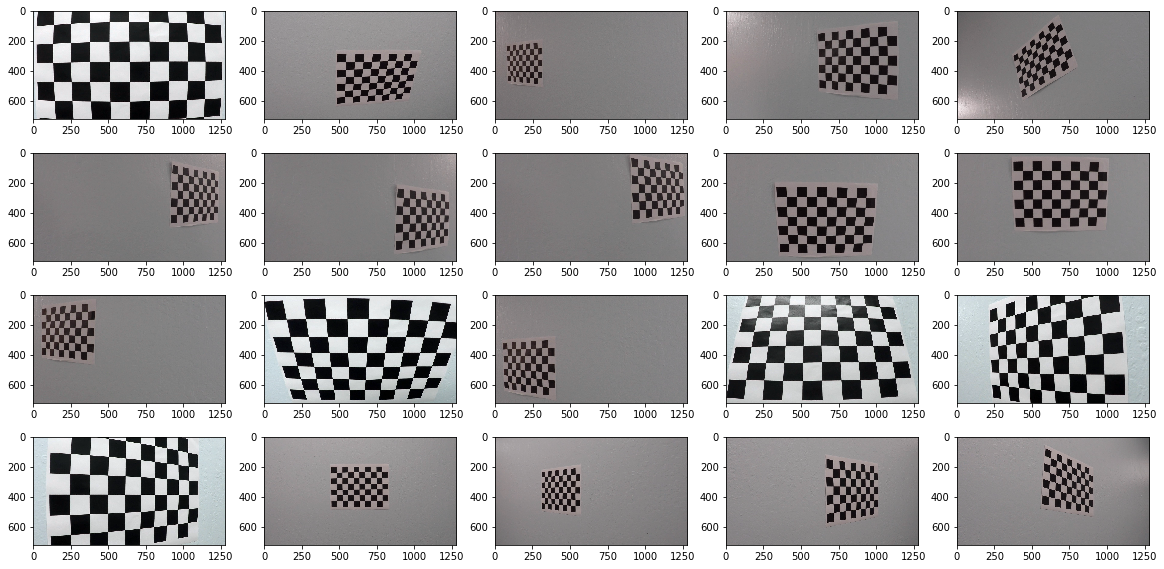

In [6]:
plt.figure(figsize=(20, 10))

for idx, fname in enumerate(images):
    img = cv2.imread(fname)
        
    plt.subplot(len(images)//5, 5, idx+1)
    plt.imshow(img)

I then used the output objpoints and imgpoints to compute the camera calibration and distortion
coefficients using the cv2.calibrateCamera() function. I applied this distortion correction to the test
image using the cv2.undistort() function and obtained the undistort image.

In [7]:
# Prepare object points
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

In [8]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

In [9]:
# Make a list of calibration images
images = glob.glob("./camera_cal/calibration*.jpg")

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

Let's see how it works on one test image first:

In [10]:
img = cv2.imread("camera_cal/calibration1.jpg")

In [11]:
# Convert image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

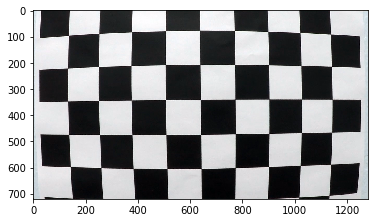

In [12]:
cv2.drawChessboardCorners(img, (9, 6), corners, ret)

plt.imshow(img)
plt.show()

Undistort image based on the camera calibration factors:

In [13]:
def undistort_image(img, objp, imgp):
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, img_size, None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

Testing our code with some image:

In [14]:
img = cv2.imread("camera_cal/calibration1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

dst = undistort_image(img, objpoints, imgpoints)

Before:


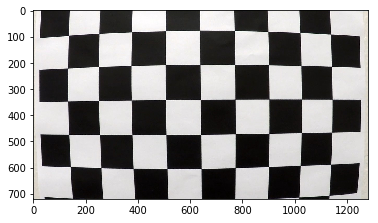

After:


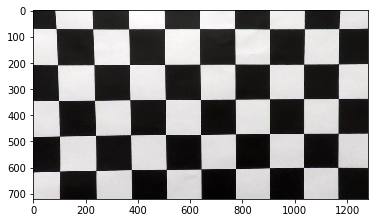

In [15]:
# Before undistort
print("Before:")
plt.imshow(img)
plt.show()

# After undistort
print("After:")
plt.imshow(dst)
plt.show()

Now we will apply it for all image in folder "camera_cal" and save it in "./output_images/camera_cal_outp"

In [16]:
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Apply undistort image
    dst = undistort_image(img, objpoints, imgpoints)
    
    # Save the result
    bgr_img = cv2.cvtColor(dst, cv2.COLOR_RGB2BGR)
    cv2.imwrite("./output_images/camera_cal_outp/" + str(idx) + ".jpg", bgr_img)

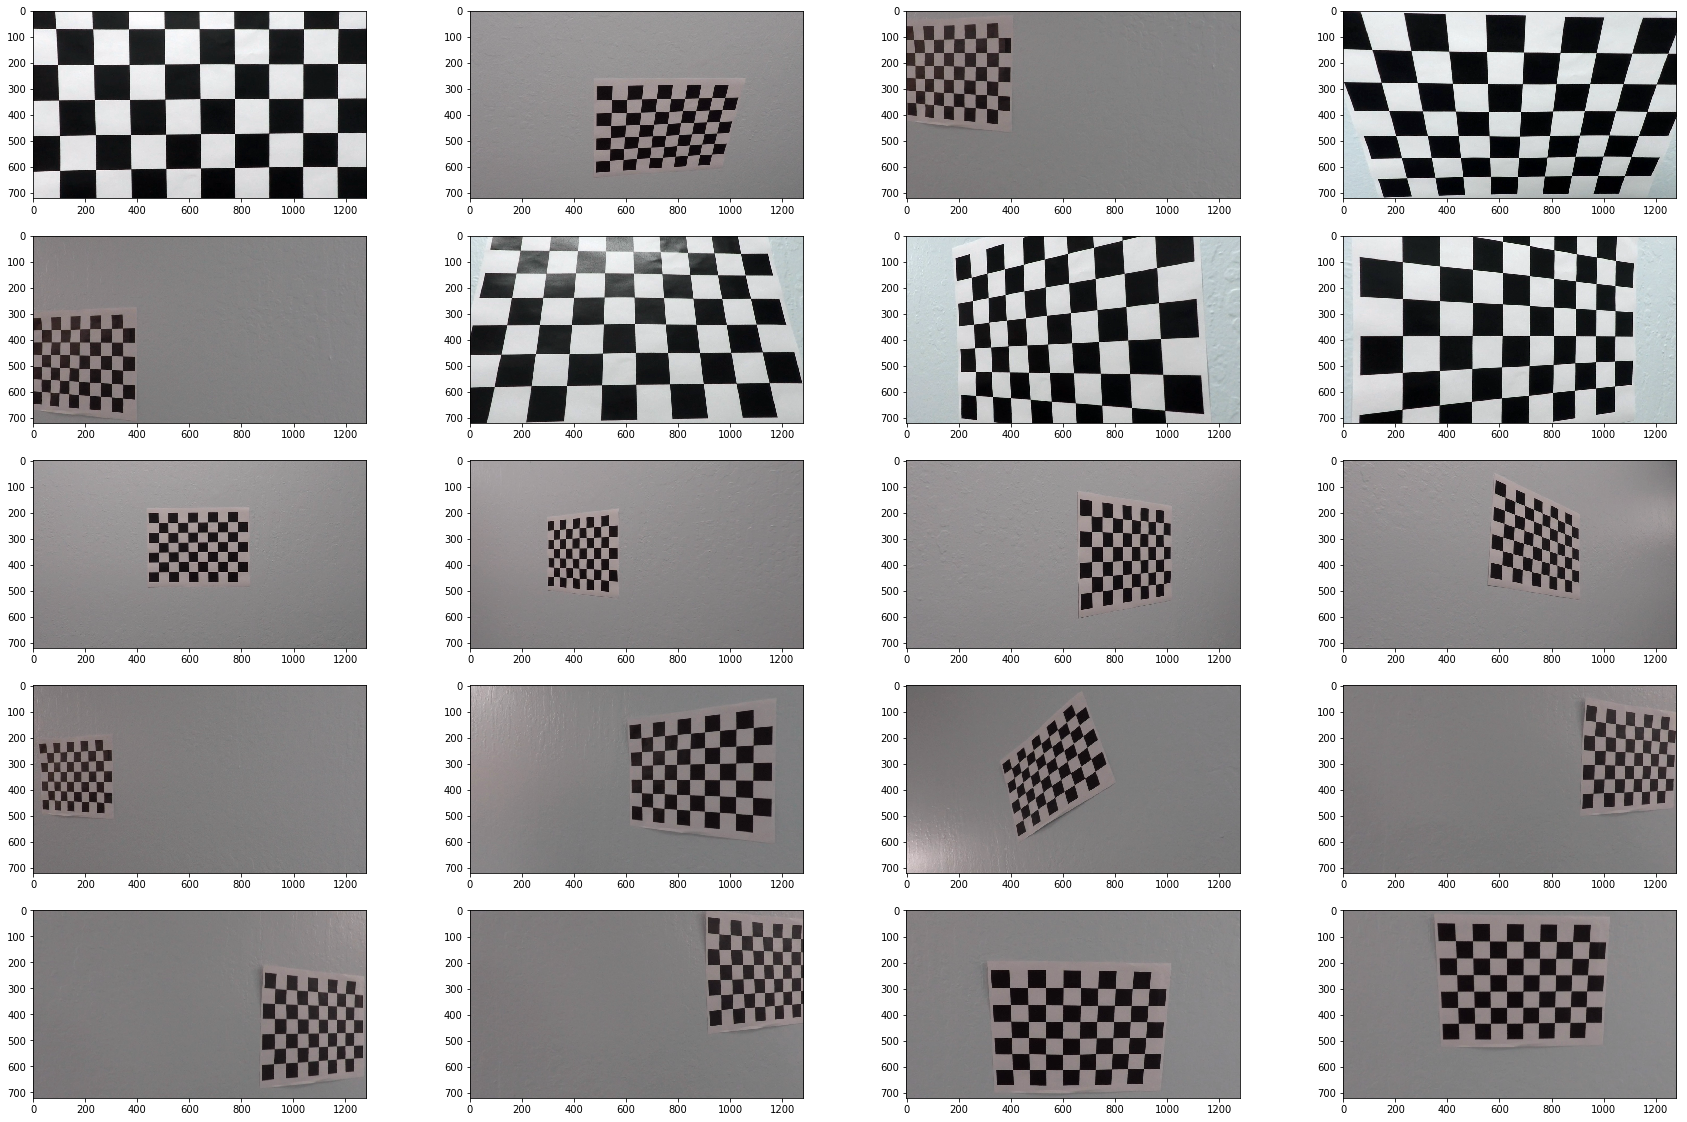

In [17]:
# Showing the result 
result_img, _ = readFiles("./output_images/camera_cal_outp/")

plt.figure(figsize=(30, 20))
for idx, fname in enumerate(result_img):
    img = cv2.imread(fname)
        
    plt.subplot(len(images)//4, 4, idx+1)
    plt.imshow(img)

### Pipeline (single images)
The undistort_image takes an image and defaults the mtx and dist variables from the previous camera calibration before returning the undistorted image. To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this:

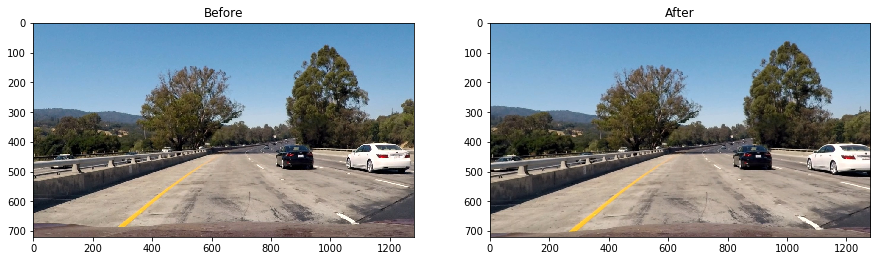

In [18]:
test_img = cv2.imread("test_images/test1.jpg")
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
dst = undistort_image(test_img, objpoints, imgpoints)

plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.imshow(test_img)
plt.title("Before")

plt.subplot(1, 2, 2)
plt.imshow(dst)
plt.title("After");

### Has a binary image been created using color transforms, gradients or other methods?

First, convert the image to HLS color-space, then use the OpenCV Sobel function to get where the gradient of an image in the X direction. Then convert the image the HSV color-space with S-channel threshold. 

In [19]:
def thresholded_binary(undistorted_img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS).astype("float")
    s_channel = hls[:,:,2]
    
    # Sobel x
    gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary

In [20]:
img = cv2.imread("./test_images/test5.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [21]:
undistorted_img = undistort_image(img, objpoints, imgpoints)
color_binary, combined_binary = thresholded_binary(undistorted_img)

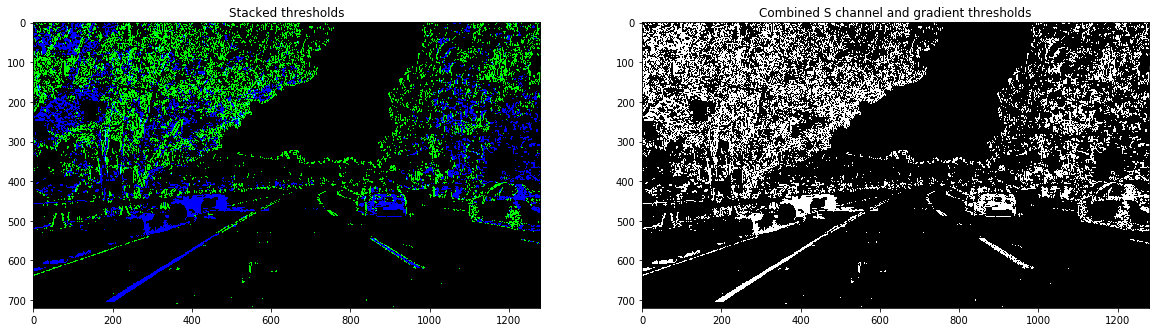

In [22]:
# Plotting thresholded images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.set_title("Stacked thresholds")
ax1.imshow(color_binary)

ax2.set_title("Combined S channel and gradient thresholds")
ax2.imshow(combined_binary, cmap="gray")

## Has a perspective transform been applied to rectify the image?

To be able to detect the road lines, the undistorted image is warped. The function calc_warp_points takes an image's height & width and then calculates the src and dst array of points. perspective_transforms takes them and returns two matrixes M and Minv for perspective_warp and perpective_unwarp functions respectively.

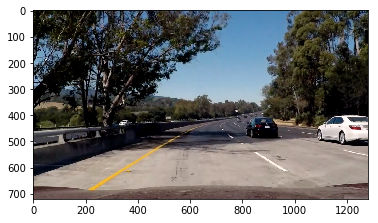

In [23]:
image_test = cv2.imread("./test_images/test5.jpg")
image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)

# Show the test image
plt.imshow(image_test)
plt.show()

In [24]:
img_size = (image_test.shape[1], image_test.shape[0])
print(img_size)

(1280, 720)


The first step is calculate the source and destination points. I chose the hardcode the source and destination points in the
following manner:

In [25]:
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

This resulted in the following source and destination points:

| Source      |    Destination	   |
|:------------|:-------------------|
| 585, 460    | 320, 0			   |
| 203, 720    | 320, 720           |
| 1127, 720	  |	960, 720    	   |
| 695, 460	  | 960, 0             |

In [26]:
src_points = src.reshape((-1, 1, 2)).astype("int32")
dst_points = dst.reshape((-1, 1, 2)).astype("int32")

I verified that my perspective transform was working as expected by drawing the src and dst points onto
a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

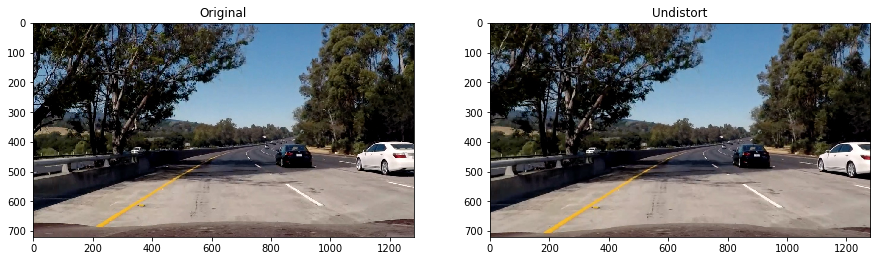

In [27]:
# Undistort test image
und_img = undistort_image(image_test, objpoints, imgpoints)

plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.imshow(image_test)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(und_img)
plt.title("Undistort");

Undistort image has the same size as original image, then we should use image_size as (width, height) of undistort one.

In [28]:
# Find the warped image
def warp_image(img, src, dst, image_size):
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped, M, Minv

In [29]:
warped, M, Minv = warp_image(und_img, src, dst, img_size)

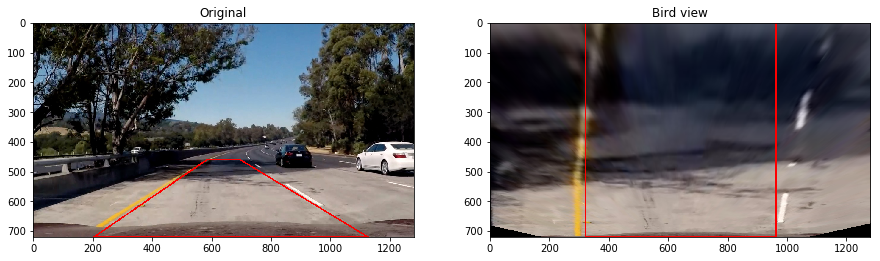

In [30]:
# Draw both undistort image and warped image
draw_image_test = np.copy(image_test)
draw_image_test = cv2.polylines(draw_image_test, [src_points], True, (255, 0, 0), thickness=3)

draw_warped = np.copy(warped)
draw_warped = cv2.polylines(draw_warped, [dst_points], True, (255, 0, 0), thickness=3)

plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
plt.imshow(draw_image_test)
plt.title("Original")

plt.subplot(1, 2, 2)
plt.imshow(draw_warped)
plt.title("Bird view");

Display the binary image of "Bird view" image:

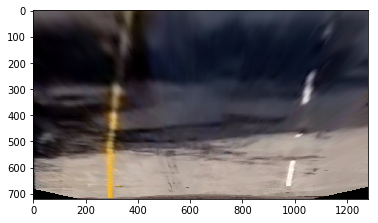

In [31]:
plt.imshow(warped)
plt.show()

In [32]:
undistorted_birdview = undistort_image(warped, objpoints, imgpoints)
color_binary, combined_binary_birdview = thresholded_binary(undistorted_birdview)

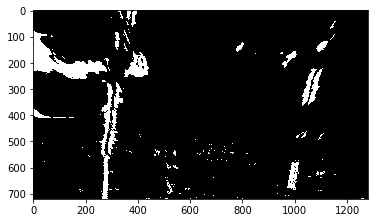

In [33]:
plt.imshow(combined_binary_birdview, cmap="gray")
plt.show()

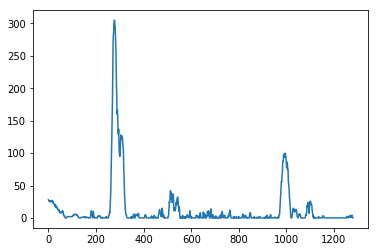

In [34]:
# Take a histogram of the bottom half of the image
histogram = np.sum(combined_binary_birdview[int(combined_binary_birdview.shape[0]/2):,:], axis=0)
plt.plot(histogram);

## Have lane line pixels been identified in the rectified image and fit with a polynomial.
In this step I find the lane lines and fit it with a 2nd order polynomial.

We already have a warped binary image, the next step is to find which "hot" pixels are associated with the lane lines. To do that, we using a histogram to find the lane lines in the bottom half of the image, then apply sliding window technique to move up and find the next part of lines.

In [35]:
binary_warped = np.copy(combined_binary_birdview)

In [36]:
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)

In [37]:
def find_peak(binary_warped):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base, rightx_base

In [38]:
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

In [39]:
# Current positions to be updated for each window
leftx_current, rightx_current = find_peak(binary_warped)

In [40]:
# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

Create an output image to draw on and  visualize the result

In [41]:
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

In [42]:
# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

In [43]:
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

In [44]:
# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]

In [45]:
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

Write as a complete function:

In [46]:
def calc_fit(leftx_current, rightx_current):
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

#### Visualization

In [47]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

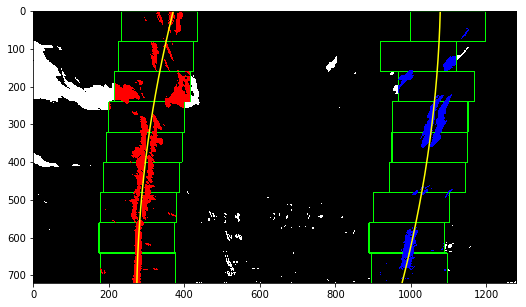

In [48]:
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

plt.figure(figsize=(10,5))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.imshow(out_img)
plt.show()

Skip the sliding windows step once you know where the lines are:

In [49]:
window_img = np.zeros_like(out_img)

In [50]:
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

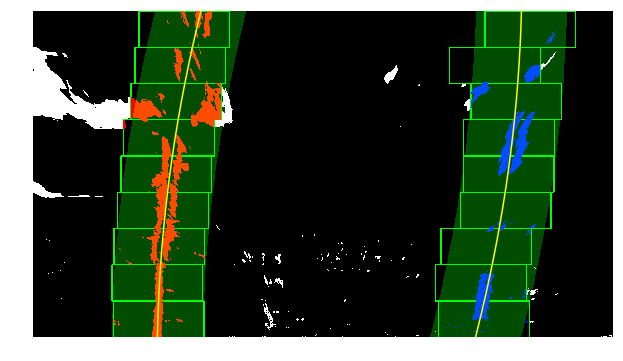

In [51]:
# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

plt.figure(figsize=(12,6))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.axis("off");

## Having identified the lane lines, has the radius of curvature of the road been estimated? And the position of the vehicle with respect to center in the lane

In [52]:
def get_curvature(leftx, lefty, rightx, righty, ploty, image_size):
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # calculate the lane deviation of the vehicle (assuming camera is in center of vehicle)
    scene_height = image_size[0] * ym_per_pix
    scene_width = image_size[1] * xm_per_pix
    
    left_intercept = left_fit_cr[0] * scene_height ** 2 + left_fit_cr[1] * scene_height + left_fit_cr[2]
    right_intercept = right_fit_cr[0] * scene_height ** 2 + right_fit_cr[1] * scene_height + right_fit_cr[2]
    calculated_center = (left_intercept + right_intercept) / 2.0
    
    lane_deviation = abs(calculated_center - scene_width) / 2.0
    
    return left_curverad, right_curverad, lane_deviation

In [53]:
left_curverad, right_curverad, lane_deviation = get_curvature(leftx, lefty, rightx, righty, ploty, img_size)

In [54]:
left_curverad

1034.6205689085525

In [55]:
right_curverad

1030.6416510268418

In [56]:
lane_deviation

0.45296853676717364

Draw the found lane lines onto a binary warped image, then unwarp and overlay on the original image.

In [57]:
def draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty):
    
    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    return result

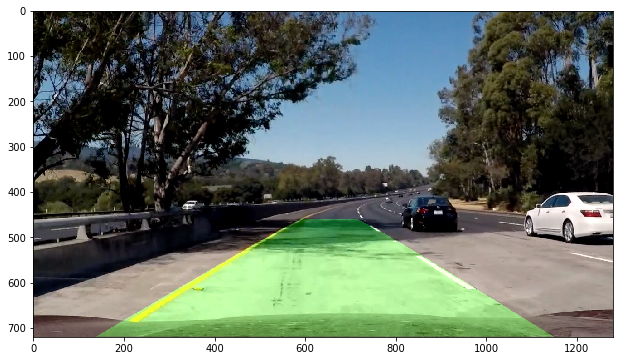

In [58]:
result = draw_lanes_on_image(binary_warped, image_test, Minv, left_fitx, right_fitx, ploty)

plt.figure(figsize=(12,6))
plt.imshow(result)
plt.show()

# Lane Detection function
Now we need to write all code in one complete function, that we can put an image in, and get the output image with lane line detected.

### Some support function

In [59]:
def calc_src_dst(image):
    img_size = (image.shape[1], image.shape[0])    
    
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])
    
    return src, dst

In [60]:
def undistort_image(img, objp, imgp):
    img_size = (img.shape[1], img.shape[0])
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objp, imgp, img_size, None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst

In [61]:
# Find the warped image
def warp_image(img, src, dst, image_size):
    
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, image_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)

    return warped, M, Minv

In [62]:
def thresholded_binary(undistorted_img):
    # Convert to HLS color space and separate the S channel
    # Note: img is the undistorted image
    hls = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2HLS).astype("float")
    s_channel = hls[:,:,2]
    
    # Sobel x
    gray = cv2.cvtColor(undistorted_img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
    
    # Threshold x gradient
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return color_binary, combined_binary

In [63]:
# Choose the number of sliding windows
nwindows = 9

In [64]:
def find_peak(binary_warped):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    return leftx_base, rightx_base

In [65]:
# Set the width of the windows +/- margin
margin = 100

# Set minimum number of pixels found to recenter window
minpix = 50

In [66]:
def calc_fit(leftx_current, rightx_current, binary_warped):
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

In [67]:
def get_curvature(leftx, lefty, rightx, righty, ploty, image_size):
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # calculate the lane deviation of the vehicle (assuming camera is in center of vehicle)
    scene_height = image_size[0] * ym_per_pix
    scene_width = image_size[1] * xm_per_pix
    
    left_intercept = left_fit_cr[0] * scene_height ** 2 + left_fit_cr[1] * scene_height + left_fit_cr[2]
    right_intercept = right_fit_cr[0] * scene_height ** 2 + right_fit_cr[1] * scene_height + right_fit_cr[2]
    calculated_center = (left_intercept + right_intercept) / 2.0
    
    lane_deviation = (calculated_center - scene_width) / 2.0
    
    return left_curverad, right_curverad, lane_deviation

In [68]:
def draw_lanes_on_image(binary_warped, undistorted_img, Minv, left_fitx, right_fitx, ploty):
    
    # Create a blank image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undistorted_img.shape[1], undistorted_img.shape[0])) 
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    return result

### Lane Detection function

In [69]:
def lane_detection_image(image):
    img_size = (image_test.shape[1], image_test.shape[0])
    
    # Undistort image
    und_img = undistort_image(image, objpoints, imgpoints)
    
    # Compute source, destination points
    src, dst = calc_src_dst(image)
    warped, M, Minv = warp_image(und_img, src, dst, img_size)
    
    undistorted_birdview = undistort_image(warped, objpoints, imgpoints)
    color_binary, combined_binary_birdview = thresholded_binary(undistorted_birdview)
    
    # Set height of windows
    window_height = np.int(combined_binary_birdview.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = combined_binary_birdview.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current, rightx_current = find_peak(combined_binary_birdview)
    
    out_img = np.dstack((combined_binary_birdview, combined_binary_birdview, combined_binary_birdview))*255
    
    
    left_fit, right_fit, leftx, lefty, rightx, righty = calc_fit(leftx_current, rightx_current, combined_binary_birdview)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, combined_binary_birdview.shape[0]-1, combined_binary_birdview.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    window_img = np.zeros_like(out_img)
    
    left_curverad, right_curverad, lane_deviation = get_curvature(leftx, lefty, rightx, righty, ploty, img_size)
    
    result = draw_lanes_on_image(combined_binary_birdview, image_test, Minv, left_fitx, right_fitx, ploty)
    
    return result, left_curverad, right_curverad, lane_deviation

### Apply to all test images

In [70]:
# Read all test image in a list
images, list_filename = readFiles("test_images")

In [71]:
list_filename

['straight_lines1.jpg',
 'straight_lines2.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

In [72]:
# Check and create folder if it's not exist
def checkFolderExist(folder_path):
    if (os.path.exists(folder_path) == True):
        print("This folder "+ folder_path +" is already exist")
    else:
        os.makedirs(folder_path)

In [73]:
# Result folder path
rel_folder_path = "./output_images/test_images_outp"

In [74]:
checkFolderExist(rel_folder_path)

This folder ./output_images/test_images_outp is already exist


test_images/straight_lines1.jpg


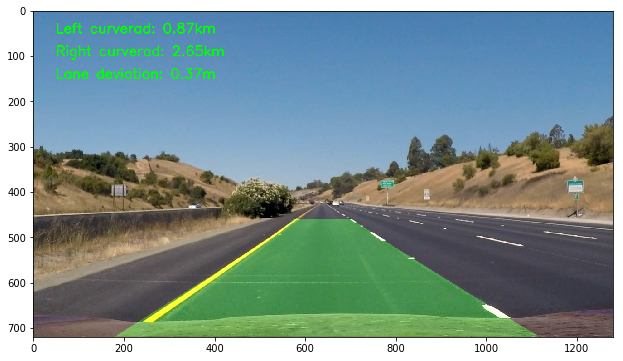

test_images/straight_lines2.jpg


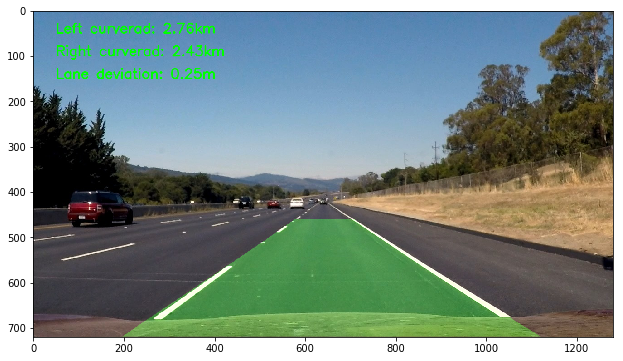

test_images/test1.jpg


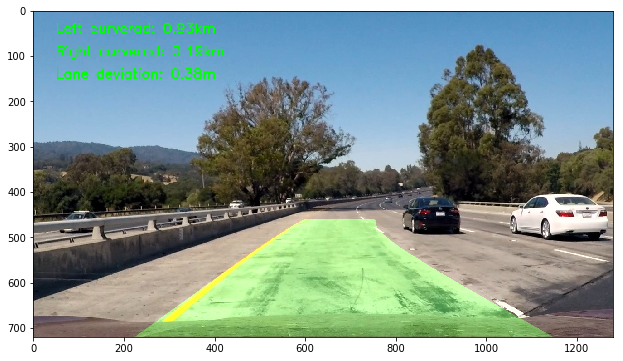

test_images/test2.jpg


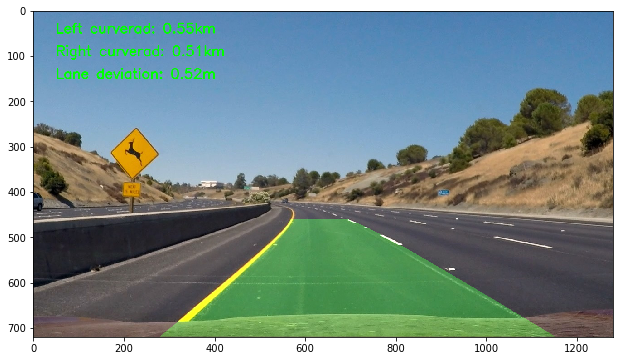

test_images/test3.jpg


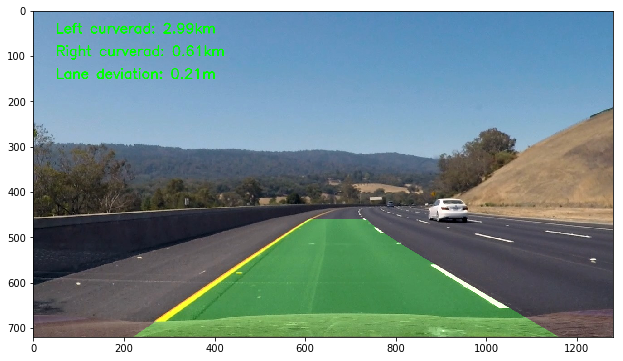

test_images/test4.jpg


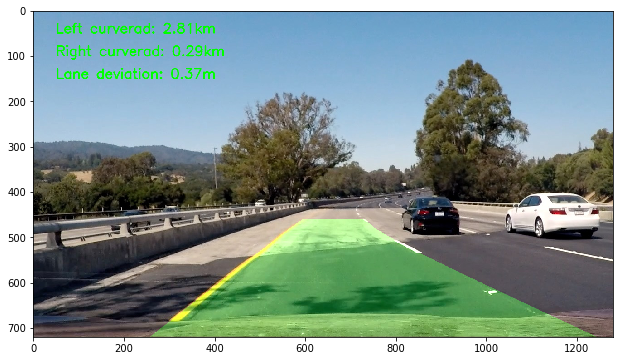

test_images/test5.jpg


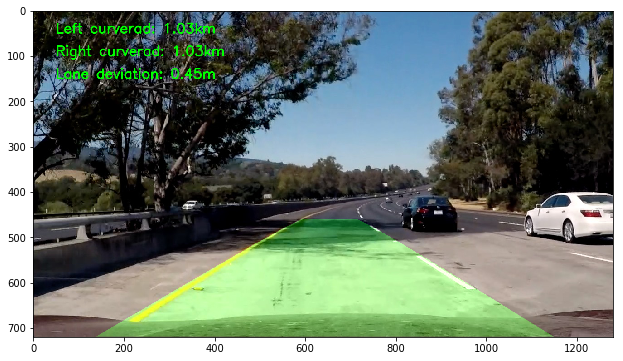

test_images/test6.jpg


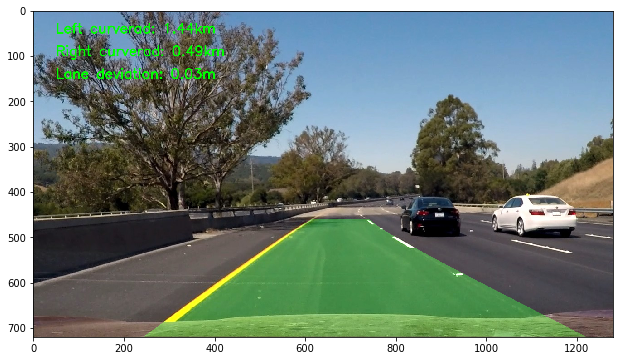

In [75]:
# For each path of image, read and detect lane lines
for path in list_filename:
    img_path = "test_images/"+path
    print(img_path)
    
    image_test = cv2.imread(img_path)
    image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)

    # output image
    outp, left_curverad, right_curverad, lane_deviation = lane_detection_image(image_test)

    # Set font text to write on image by openCV
    font = cv2.FONT_HERSHEY_SIMPLEX

    #Set text
    left_curverad_text = "Left curverad: " + str(round(left_curverad/1000, 2)) + "km"
    right_curverad_text = "Right curverad: " + str(round(right_curverad/1000, 2)) + "km"
    lane_deviation_text = "Lane deviation: " + str(round(abs(lane_deviation), 2)) + "m"

    # Write text to output image
    cv2.putText(outp, left_curverad_text, (50, 50), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(outp, right_curverad_text, (50, 100), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    cv2.putText(outp, lane_deviation_text, (50, 150), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Save images
    path = rel_folder_path+"/"+ path
    
    outp_save = cv2.cvtColor(outp, cv2.COLOR_BGR2RGB)
    cv2.imwrite(path, outp_save)
    
    plt.figure(figsize=(12,6))
    plt.imshow(outp)
    plt.show()

## Pipeline (video)
Does the pipeline established with the test images work to process the video?

In [76]:
import imageio

# Run this download command if necessary
#imageio.plugins.ffmpeg.download()

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [77]:
# Change the filename to run with another files
# filename = "./project_video.mp4"
filename = "./challenge_video.mp4"

In [78]:
# Capture this video
cap = cv2.VideoCapture(filename)

# Get height, width and FPS (frames per second) of video
vid_height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
vid_width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
vid_fps = cap.get(cv2.CAP_PROP_FPS)

In [79]:
# Choose another values of fourcc like H264, XVID etc. to save the video output as you want
# fourcc = cv2.VideoWriter_fourcc(*'X264')
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
# fourcc = cv2.VideoWriter_fourcc(*'XVID')


In [80]:
# Define a parameter to write output video
out = cv2.VideoWriter('output_images/'+filename, fourcc, vid_fps, (int(vid_width), int(vid_height)))

The code below will read a test video name: 'project_video.mp4', detects lane lines and save the result as file name 'output_images/project_video.mp4'

#### Warning: code block below will write down the video result, it might re-write the existed video

In [81]:
i = 0;
while (cap.isOpened()):
    print(i+1)
    i += 1
    ret, image_test = cap.read()
    
    if ret==True:
#         image_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2RGB)
        # output image
        outp, left_curverad, right_curverad, lane_deviation = lane_detection_image(image_test)

        # Set font text to write on image by openCV
        font = cv2.FONT_HERSHEY_SIMPLEX

        #Set text
        left_curverad_text = "Left curverad: " + str(round(left_curverad/1000, 2)) + "km"
        right_curverad_text = "Right curverad: " + str(round(right_curverad/1000, 2)) + "km"
        lane_deviation_text = "Lane deviation: " + str(round(abs(lane_deviation), 2)) + "m"

        # Write text to output image
        cv2.putText(outp, left_curverad_text, (50, 50), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(outp, right_curverad_text, (50, 100), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
        cv2.putText(outp, lane_deviation_text, (50, 150), font, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Write output video
        out.write(outp)
    else:
        break

cap.release()
out.release()
cv2.destroyAllWindows()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


## Show the result

In [83]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("./output_images/project_video.mp4"))